In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Assignment \#2: Simple Machine Learning Pipeline

Ben Fogarty  
University of Chicago, Harris School of Public Policy  
CAPP 30254: Machine Learning for Public Policy  
Spring 2019

## Project overview & requirements

This project's folder contains the following files:

- writeup.ipynb: the assignment write up
- pipeline_library.py: general functions for a machine learning pipeline (reading data, preprocessing data, generating features, building models, etc.)
- predict_financial.py: specific functions for applying the functions in pipeline_library to predicting who will experience financial distress within the next two years
- tree.pdf: a visualization of the decision tree generated in this model
- credit-data.csv: the dataset used for training and testing the tree predicting who will experience financial distress within the next two years
- data-dictionary.csv: dictionary describing the dataset in credit-data.csv
- hw2.pdf: the assignment statement

The project was developed using Python 3.7.3 on MacOS Mojave 10.14.4. It requires the following libraries:

| Package        | Version     |
| :------------: | :---------: |
| graphviz       | 2.40.1      |
| pandas         | 0.24.2      |
| matplotlib     | 3.0.3       |
| numpy          | 1.16.2      |
| seaborn        | 0.9.0       |
| scikit-learn   | 0.20.3      |

Helpful documentation and references are cited throughout the docstrings of the code.

## Building a simple machine learning pipeline

All code for this portion of the project is located in the pipeline_library module. Excerpts from this module are included throughout.

### Read data

The pipeline_library module provides a function, read_csv, which imports CSV files into pandas dataframes, optionally allowing for the user to specify which columns to import from the csv, what the type of the columns should be in the resulting dataframe, and an index column. This function simply wraps the read_csv function provided by the pandas library.

### Explore data

The pipeline_library module also provides a suite for functions for exploratory data analysis. The first, show_distribution, returns a histogram and box plot for variable with a numeric type, and a bar plot for variables with a non-numeric type.

The next, pw_correlate, calculates a table of pairwise correlations between numeric type variables. The user can optionally specify which variables to include pairwise correlations for, and enable visualization. If visualization is enabled, the function also generates a heat map to help the user identify strong correlations.

The function summarize_data provides summary statistics over numeric data columns. By default, the function summarizes over all numeric columns, however, the user can restrict the summary statistics to certain numeric columns using the agg_cols positional keyword. Additonally, the user can also change the aggregating functions; the default are mean, variance, and quartiles. Lastly, the user can also chose to group observations based on one or more categorical variables and then compute summaries over each group. This functionality can be helpful for seeing the relationship between categorical variables and other numeric type variables.

The final function for exploratory data analysis, find_outliers, relies on a helper function find_outlier_univariate. The find_outliers function identifies the outliers in each numeric column of a dataframe, then records the number and percent of evaluated columns for which an observation is an outlier. The return values is a dataframe that links each row contains booleans describing whether the associated row in the passed in dataframe is considered an outlier for each numeric column and the numer and percent of evaulated columns for which the associated row is considered an outlier. For the pruposes of this analysis, an outlier is falling more than 1.5x the interquartile range below the 25th percentile value or more than 1.5x the interquartile range above the 75th percentile value. Optionally, the user can exclude certain columns from this procedure with the keyword argument excluded.

### Preprocess Data

The preprocess_data function in the pipeline_library module also relies on a helper function, replace_missing. At this time, the only preprocessing step is to replace missing vaules for any variables that have missing values. The replace_missing function take one column of a dataframe in the form of a series as its input. It then determines wheter the series contains numeric type data, and if so, replaces the missing values with the median value in the series. If the series does not contain numeric type data, the data is assumed to be unordered categorical data, and the functions replaces missing values with the modal value in the series, since a median cannot be calculated for unordered categorical data. The preprocess_data functions applies this algorithm for replacing missing data to all the columns of a given dataframe.

### Generate features/predictors

To discretize a continuous variable, the pipeline_library module provies the cut_variable function. This functions takes in a single columns of a dataframe (in the form of a pandas series) and returns that column discretized into bins. The user can either specify a list of "edges" for the bins (for example \[0, 0.5, 1.0\] would create the bins \[0, 0.5) and \[0.5, 1) ) or a number of bins, which creates n approximately equipercentile bins. The user can also specify labels for the bins.

Though the pandas library contains a function, pd.cut, which can be used to discretize continuous data, I decided to write a custom function for greater control over choosing bin size and greater certainty about how continuous variables are being discretized.

To convert a categorical varaible into a set of dummy variables, the pipeline_library module also provides another custome function, create_dummies. This function takes in a dataframe and the name of the column to create dummies from, and returns a new dataframe with the categorical column remove and the new dummy columns appended to the end of the dataframe. 

The pandas library also provides a function to convert categorical varaibles to dummies, pd.get_dummies. I chose to write a custom function, however, because I was dissatisfied with how the pandas library encodes missing data (it makes all dummies false where the categorical column is NA, whereas the function in pipeline_library makes dummies with missing values where the categorical column is NA) and to provide the opportunity for additional customization in the future.

### Build Classifier

The pipeline designed for this project can be used to generate a Decision Tree Classifier using the generate_decision_tree function. The function takes in training data in the form of a pandas dataframe of features, and pandas series of labels for the same observations, and optionally an instance of sklearn.tree.DecisionTreeClassifier. By default, the decision tree generated by this function uses all the default values specified in the sklearn.tree.DecisionTreeClassifier object ([see the documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)), except it uses information gain instead of Gini impurity as its criterion for splitting. The optional decision tree parameter allows for the user to customize the properties of the DecisionTreeClassifier by instantiating a sklearn.tree.DecisionTreeClassifier and passing it to the function. If the user passes a DecisionTreeClassifier object, that object is used instead of the default decision tree generate by the function. 

### Evaluating Classifier

A simple function, score_decision_tree, returns the mean accuracy of a decision tree when used to predict the target attribute for a set of observations where the value of the target attribute is known. The function takes in a decision tree, and a set of testing data in the form of a pandas dataframe of features (in the same order as the data on which the tree was trained) and a pandas series of classes for the same observations.

### Visualizing Classifier

Lastly, the function visualize_decision_tree saves and opens a PDF containing a visual representation of a DecisionTreeClassifer. For this function, the user must provide a decision tree, a list of feature names in the same order as the data on which the tree was trained, and the list of class names for the target attribute that the tree predicts. Optionally, the user may also specify an output path for the generate PDF.

## Applying the simple machine learning pipeline

All the code for this portion of the project is in the predict_financial module, and can be run from the command line with the command.

```
add command here
```
For the purposes of this write-up, however, I will step through the code in that module.

Before we being, we load in the pipeline_library module with the alias pl.

In [2]:
import pipeline_library as pl

### Reading in the data

The data required for this project is located in a file in the root of the project directory titled credit-data.csv. We load it in using the function from the pipeline created in the first section.

Based on the data dictionary, we specify that all columns except the zipcode column be loaded in as floats since they either represent numeric data or represent booleans but may contain missing data. The zipcode column is read in as a string because it contains categorical data. PersonID is specified as the index column.

In [43]:
col_types = {'SeriousDlqin2yrs': float,
             'RevolvingUtilizationOfUnsecuredLines': float,
             'age': float,
             'NumberOfTime30-59DaysPastDueNotWorse': float,
             'zipcode': str,
             'DebtRatio': float,
             'MonthlyIncome': float,
             'NumberOfOpenCreditLinesAndLoans': float,
             'NumberOfTimes90DaysLate': float,
             'NumberRealEstateLoansOrLines': float,
             'NumberOfTime60-89DaysPastDueNotWorse': float,
             'NumberOfDependents': float}
df = pl.read_csv('credit-data.csv', col_types=col_types, index_col='PersonID')

Looking at the first five rows and one individual row from the dataframe we just loaded in:

In [4]:
df.head(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
PersonID,,,,,,,,,,,,
98976,0.0,1.000000,55.0,60601,0.0,505.000000,0.0,2.0,0.0,0.0,0.0,0.0
98991,0.0,0.547745,71.0,60601,0.0,0.459565,15666.0,7.0,0.0,2.0,0.0,0.0
99012,0.0,0.044280,51.0,60601,0.0,0.014520,4200.0,5.0,0.0,0.0,0.0,0.0
99023,0.0,0.914249,55.0,60601,4.0,0.794875,9052.0,12.0,0.0,3.0,0.0,0.0
99027,0.0,0.026599,45.0,60601,0.0,0.049966,10406.0,4.0,0.0,0.0,0.0,2.0


In [5]:
df.iloc[0]

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        1
age                                        55
zipcode                                 60601
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                 505
MonthlyIncome                               0
NumberOfOpenCreditLinesAndLoans             2
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                          0
Name: 98976, dtype: object

Each row has its person ID as its index, and each row contains 12 columns/variables. Since our goal is to predict financial delinquency within the next two years, we anticipate that our target attribute will be SeriousDlqin2yrs.

### Explore Data

Before building our model, we first explore our data, looking for the distribution of each variable, any correlations, notable outliers, and other summaries.

To being, we use use the summarize_data function from our pipeline to generate the mean, variance, and quartiles of each numeric type variable in our dataset, ignoring missing values.

In [6]:
summary = pl.summarize_data(df)

In [7]:
summary

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,41016.0,0.161400,0.367904,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,41016.0,6.375870,221.618950,0.0,0.034310,0.189730,0.667160,22000.0
age,41016.0,51.683489,14.746880,21.0,41.000000,51.000000,62.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,41016.0,0.589233,5.205628,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,41016.0,331.458137,1296.109695,0.0,0.176375,0.369736,0.866471,106885.0
MonthlyIncome,33042.0,6578.995733,13446.825930,0.0,3333.000000,5250.000000,8055.750000,1794060.0
NumberOfOpenCreditLinesAndLoans,41016.0,8.403477,5.207324,0.0,5.000000,8.000000,11.000000,56.0
NumberOfTimes90DaysLate,41016.0,0.419592,5.190382,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,41016.0,1.008801,1.153826,0.0,0.000000,1.000000,2.000000,32.0
NumberOfTime60-89DaysPastDueNotWorse,41016.0,0.371587,5.169641,0.0,0.000000,0.000000,0.000000,98.0


Looking at these summaries, the first thing of note is the relative infrequency of financial distress within the previous 2 years among our observations. Only 16% of the observations experience 90 days past due delinency or worse within the past two years.

Next, I notice that the max of Revolving Utilization of Unsecured Lines is 220,000 despite the variable being described as a percentage in the data dictionary. This value is surprising becuase this varaible is the proportion of an individual's total balance on certain personal lines of credit to the sum of the credit limits on these lines, so it seems that this value should be bounded closer to 1. It's possible that this is a miscoding, however, it may also be that an individual had numerous credit lines revoked, causing their revolving utilization to become very high. It'll be important to look for whether there are other similarly high values when we show the distribtuion of that data.

Other noteworth takeaways from this data summary is that the monthly income variable is highly spreadout, with a standard deviation of 13,447 (more than twice its mean). Additionaly, many other the varaibles describing individual's credit history or current credit usage are tightly distributed (having minimum values and 75th percentiles that are very close to one another) but one or more substantial outliers (visible through extremely high maximum values. Examples of variables demonstrating this include NumberOfTimes30-59DaysPastDueNotWorse, NumberOfOpenCredinLinesAndLoans, NumberOfTimes90DaysLate, NumberRealEstateLoansOrLInes, and NumberOfTimes60-89DaysPastDueNotWorse.

Next, we use the pw_correlate function in our pipeline with the visualize option enabled to see a correlation matrix between all the numeric varialbles in our data.

<IPython.core.display.Javascript object>


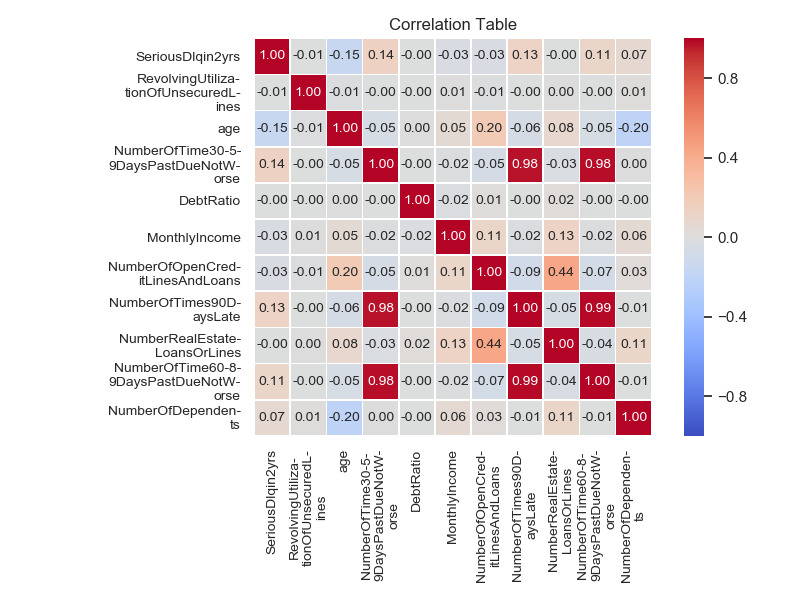

In [8]:
correlate = pl.pw_correlate(df, visualize=True)

In [9]:
correlate

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.006503,-0.152462,0.144919,-0.004334,-0.032810,-0.034495,0.129647,-0.004545,0.108975,0.065389
RevolvingUtilizationOfUnsecuredLines,-0.006503,1.000000,-0.008925,-0.001630,-0.001146,0.005832,-0.014338,-0.001594,0.002381,-0.001200,0.010279
age,-0.152462,-0.008925,1.000000,-0.054464,0.003723,0.048138,0.196067,-0.055686,0.078648,-0.049221,-0.204317
NumberOfTime30-59DaysPastDueNotWorse,0.144919,-0.001630,-0.054464,1.000000,-0.001386,-0.015224,-0.054963,0.975480,-0.028853,0.981599,0.002203
DebtRatio,-0.004334,-0.001146,0.003723,-0.001386,1.000000,-0.022988,0.014790,-0.002675,0.015829,-0.001696,-0.001443
MonthlyIncome,-0.032810,0.005832,0.048138,-0.015224,-0.022988,1.000000,0.107100,-0.017954,0.127313,-0.015336,0.060528
NumberOfOpenCreditLinesAndLoans,-0.034495,-0.014338,0.196067,-0.054963,0.014790,0.107100,1.000000,-0.087372,0.437245,-0.073760,0.030790
NumberOfTimes90DaysLate,0.129647,-0.001594,-0.055686,0.975480,-0.002675,-0.017954,-0.087372,1.000000,-0.048272,0.987877,-0.005589
NumberRealEstateLoansOrLines,-0.004545,0.002381,0.078648,-0.028853,0.015829,0.127313,0.437245,-0.048272,1.000000,-0.040207,0.106386
NumberOfTime60-89DaysPastDueNotWorse,0.108975,-0.001200,-0.049221,0.981599,-0.001696,-0.015336,-0.073760,0.987877,-0.040207,1.000000,-0.007141


Looking at this correlation table and the associated visualization, the strongest correlations appear to be between the different variables denoting past the number of times a borrower has been past due, with all the pairwise correlations between NumberOfTimes30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse, and number of NumberOfTimes90DaysLate being at or above 0.98. Relative to the rest of the dataset, there also appears to be a strong positive correlation between the Numer of Real Estate Loans/Credit Lines and the Number of Open Credit and Loan Lines, with a correlation of coeffiecient of 0.44.

Looking at our target attribute, SeriousDlqin2yrs, there are no other variable with a particularly strong correlation with it.

Since zipcode is a categoerical variable, it was not include in the pairwise correlations table. Instead, we consider it separately by grouping the databy zipcode and displaying various summary statistics. For simplicity, we limit the output to the means of each variable.

In [10]:
by_zip = pl.summarize_data(df, grouping_vars='zipcode')

In [11]:
by_zip.xs('mean', axis=0, level=1)

zipcode,60601,60618,60625,60629,60637,60644
SeriousDlqin2yrs,0.169753,0.176406,0.169560,0.166744,0.180516,0.000000
RevolvingUtilizationOfUnsecuredLines,5.426326,3.533973,5.848579,6.410459,10.909085,7.113789
age,51.650848,51.623026,51.720707,51.498529,51.426503,52.840945
NumberOfTime30-59DaysPastDueNotWorse,0.528551,0.665824,0.625310,0.554265,0.699559,0.181496
DebtRatio,326.090201,351.840384,318.771680,319.513465,355.413892,329.127883
MonthlyIncome,6939.742488,6414.652413,6506.113519,6437.078613,6389.541109,7274.661621
NumberOfOpenCreditLinesAndLoans,8.569784,8.338598,8.398171,8.329463,8.330973,8.540945
NumberOfTimes90DaysLate,0.344951,0.499368,0.464585,0.380709,0.510072,0.053543
NumberRealEstateLoansOrLines,1.002023,1.005843,1.017746,0.988233,1.017312,1.018898
NumberOfTime60-89DaysPastDueNotWorse,0.306208,0.440145,0.408478,0.336585,0.465376,0.033071


Based on the means, individuals living in the 60644 zipcode appear to have a much more secure financial status that those living in the other zipcodes. None of the observations for individuals living in the 60644 area code reported expreiencing 90 days past due delinquency within the past 2 years, and there were substantially lower percents of all levels of being past due among these observations.

Between the other zipcodes, there is some variation in these measures of financial health, however, none of these diffedrences are as substantial as those between the 60644 and each of the other zipcodes.

Next, we loop over all the variable in the dataset, and generate figures showing their distribution with the pipeline's show_distribution function. For numeric type variables, we generate two charts, a histogram and a box plot. For all other variables, we generate a simple bar chart. To generate these charts, we 

<IPython.core.display.Javascript object>


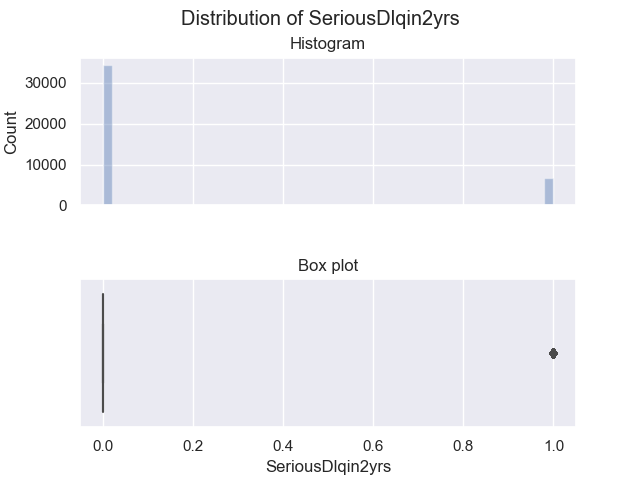

<IPython.core.display.Javascript object>


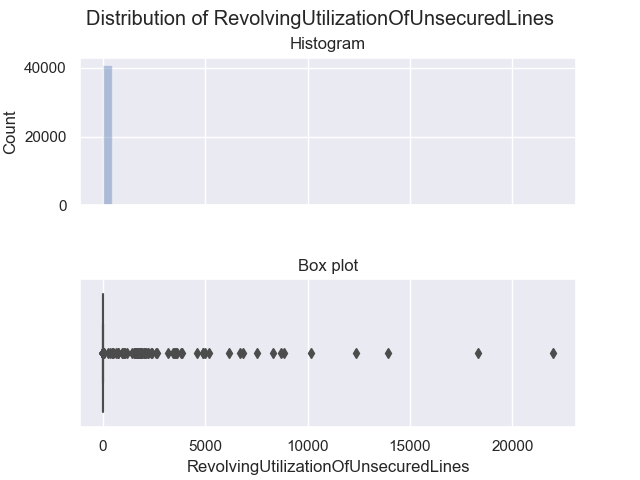

<IPython.core.display.Javascript object>


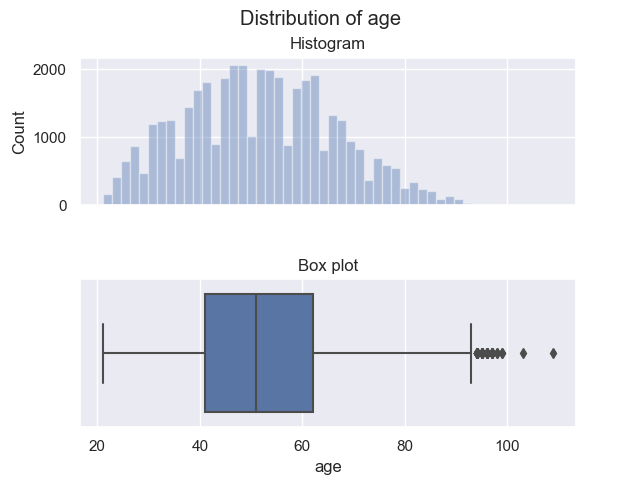

<IPython.core.display.Javascript object>


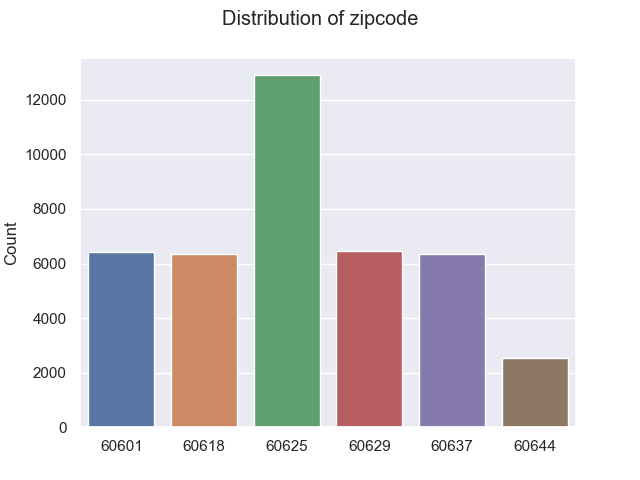

<IPython.core.display.Javascript object>


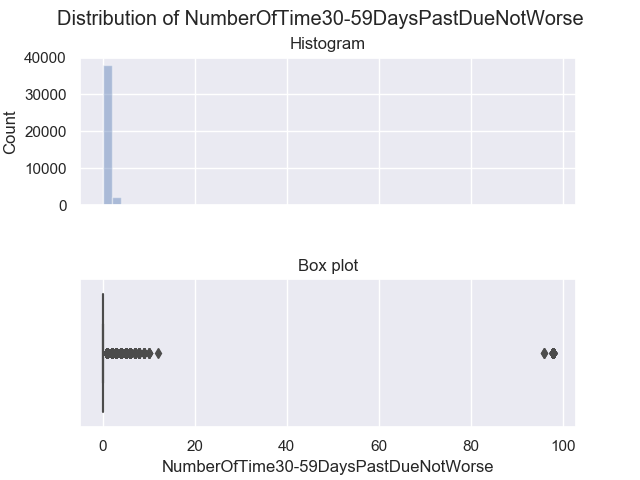

<IPython.core.display.Javascript object>


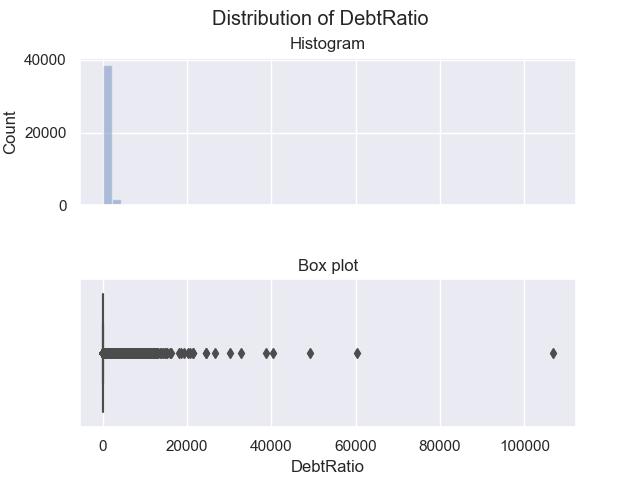

<IPython.core.display.Javascript object>


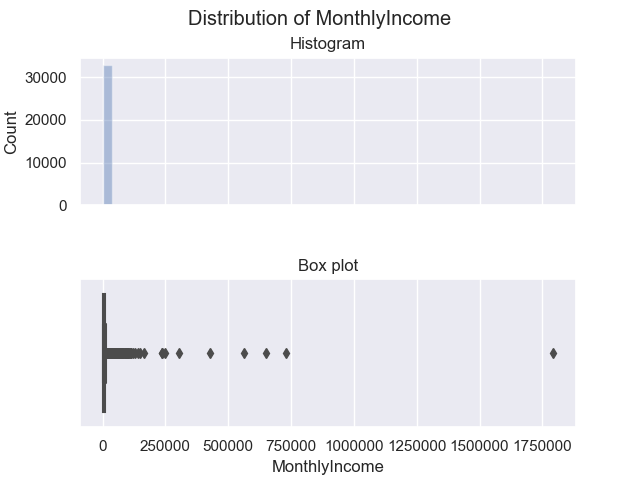

<IPython.core.display.Javascript object>


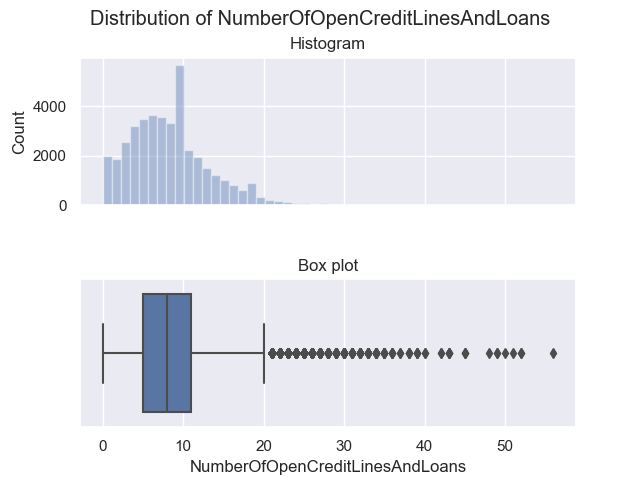

<IPython.core.display.Javascript object>


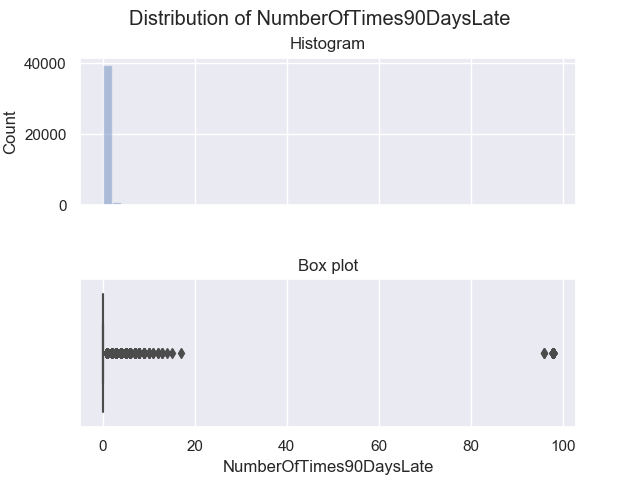

<IPython.core.display.Javascript object>


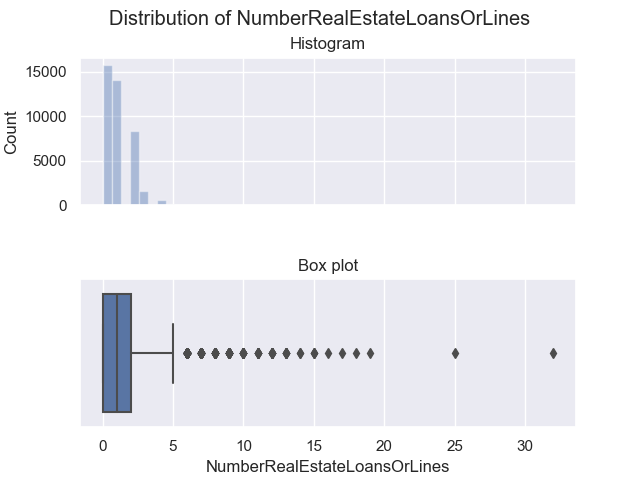

<IPython.core.display.Javascript object>


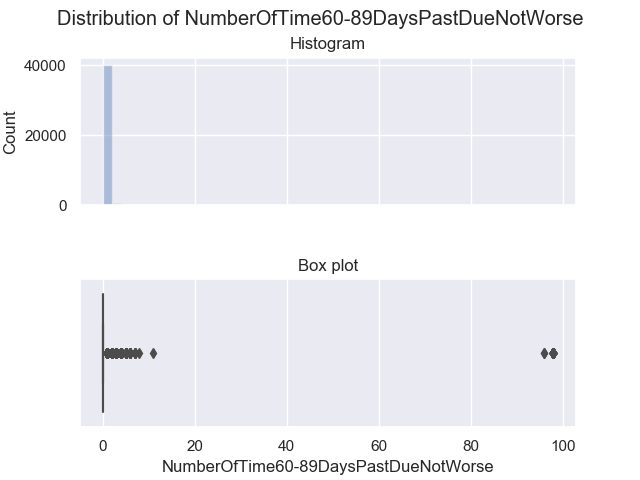

<IPython.core.display.Javascript object>


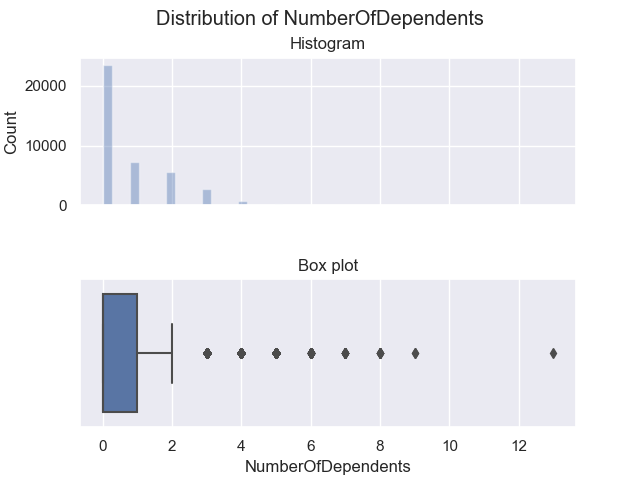

In [12]:
for var in df.columns:
    pl.show_distribution(df[var].dropna()).show()

Looking through these plots, may variables, particularly those representing credit history or characteristics, have most observations clustered near zero but extremely long right tail. To avoid overfitting, these it may be a good idea to cluster these variable before training the model, perhaps including all those above and below the 75th percentile. Alternatively, for some such as monthly income, which actually display quite a bit of variance that is obscured by the long right tails in these graphs, it may be more appropriate to create equi-percentiles bins.

Debt ratio, which we previously noted the presence of a possibly odd value in, actually has numerous observations with different extremely high values, likely indicating that these values are not miscodings.

Finally, we generate a table summarizing how many categories each variable is an outlier in.

In [13]:
outliers = pl.find_outliers(df)

In [14]:
outliers['Count Outlier'].value_counts().sort_index()

0    18915
1    13640
2     4719
3     2287
4     1143
5      288
6       23
7        1
Name: Count Outlier, dtype: int64

In [15]:
outliers.drop(['Count Outlier', '% Outlier'], axis=1).sum().sort_values()

age                                       45
RevolvingUtilizationOfUnsecuredLines     207
NumberRealEstateLoansOrLines             255
NumberOfOpenCreditLinesAndLoans         1086
MonthlyIncome                           1392
NumberOfTime60-89DaysPastDueNotWorse    3028
NumberOfTimes90DaysLate                 3430
NumberOfDependents                      3726
SeriousDlqin2yrs                        6620
NumberOfTime30-59DaysPastDueNotWorse    7934
DebtRatio                               8373
dtype: int64

Overall, a majority of our datapoints are considered outliers in one or more of the numeric variables in our dataset. The variable with the least number of outliers is age, followied by Revolving Utilization, and then Number of Real Estate Loans/Lines. The variable with the greatest number of outleirs is Debt Ration, follwed by the Number of Times 30-59 days past due, and wheter a person had been 90 day past due deliquent or worse within the past two years. 

These finding are not entirely surprising given the distribution grpah, which showed most measure of credit history had extrememly long right tails, and the correlation table showing strong correlations between variables describing credit history/status.

### Preprocess Data

To replace the missing data with the median value in numerical categories and the modal value for categorical variables, we simply use the preprocess_data function from our pipeline.

In [16]:
df = pl.preprocess_data(df)

In [20]:
df.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
zipcode                                 0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

As we can now see above, out data set contains no missing values.

### Generate Features

To generate features, we will use two methods from the pipeline, cut_variables and create_dummies. The first will be used to bin/discretize continuous variables, and the second will be used to convert categorical variables into numerical type dummy variables so that they are compatible with scikit learn.

The first feature to generate is converting the categorical variable representing zipcodes to dummy variables.

In [22]:
df = pl.create_dummies(df, 'zipcode')

In [25]:
list(df.columns)

['SeriousDlqin2yrs',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents',
 'zipcode_60625',
 'zipcode_60629',
 'zipcode_60601',
 'zipcode_60637',
 'zipcode_60618',
 'zipcode_60644']

Next, I'd like the monthly income varible into 20 equipercentile groups (i.e. 20 groups each containing approximately the same percent (5%) of the observations) and then turn that categorical variable into a set of dummies.

In [44]:
df.MonthlyIncome = pl.cut_variable(df.MonthlyIncome, 20)
df = pl.create_dummies(df, 'MonthlyIncome')